In [1]:
# Importing modules
import pandas as pd
import numpy as np
import os
import re
# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
# Import the wordcloud library
from wordcloud import WordCloud
# Visualize the topics
import pyLDAvis.gensim
import pickle 
import pyLDAvis

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv('../data/yoga.csv')

In [3]:
df.head()

,id,title,description,channelTitle,tags,categoryId,duration,viewCount,likeCount,dislikeCount,commentCount
0,sTANio_2E0Q,20 min Full Body STRETCH/YOGA for STRESS & ANX...,De-stress with this 20 minute calming yoga rou...,MadFit,"20 min full body stretch, full body stretch, s...",22,PT20M56S,5533960.0,105260.0,1727.0,3044.0
1,GLy2rYHwUqY,Total Body Yoga - Deep Stretch | Yoga With Adr...,Total Body Yoga is a deep stretch practice for...,Yoga With Adriene,"total body yoga, yoga practice, yoga at home, ...",26,PT45M13S,13443080.0,131111.0,3301.0,5233.0
2,4pKly2JojMw,10 min Morning Yoga Full Body Stretch,"Stretch out stiff, tired and achy muscles with...",Yoga with Kassandra,"10 minute morning yoga, morning yoga routine, ...",26,PT10M56S,18857966.0,339861.0,4605.0,5564.0
3,b1H3xO3x_Js,Full Body Flow | 20 Min. Yoga Practice | Y...,Set an intention and get ready to get the juic...,Yoga With Adriene,"free yoga videos, yoga at home, morning yoga, ...",26,PT19M18S,6541616.0,65820.0,1335.0,2031.0
4,A0pkEgZiRG4,10 Minute Yoga Full Body Stretch,This is a 10 minute yoga full body stretch to ...,Yoga With Bird,"yoga, yoga full body stretch, full body stretc...",26,PT10M7S,705284.0,13947.0,556.0,422.0


In [4]:
df['description'].fillna('<no description>', inplace=True)
df['tags'].fillna('<no tags>', inplace=True)

In [5]:
def clean_text(text):
    head, sep, tail = text.partition('\n\n')
    return head

In [6]:
df['description'] = df['description'].apply(clean_text)

In [7]:
df['description'][0]

'De-stress with this 20 minute calming yoga routine that includes light and easy full body stretches for stress relief and anxiety.'

In [8]:
to_clean = ['title', 'description', 'tags']

In [9]:
# remove english words
for i in to_clean:
    df[i] = df[i].map(lambda x: re.sub('([^\x00-\x7F])+','', x))

In [10]:
df['documents'] = df['title'] + ' ' + df['description'] + ' ' + df['tags']

In [11]:
df_ = df.sample(1000, random_state=1).reset_index()

In [139]:
# tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations and special characters



yoga_stopwords = ['yoga', 'practice', 'guide', 'minute', 'beginner', 'beginners', 'exercise', 'morning', 'pose', 'full', 'tag', 
                  'video', 'hour', 'posture', 'stretch', 'help', 'pose', 'sequence', 'day', 'patreon', 'support', 'donate', 
                  'visit', 'https', 'http', 'www', 'session', 'class', 'body', 'workout', 'free', 'music', 'home', 'online',
                  'child', 'calm', 'good', 'learn', 'teach', 'teacher', 'com', 'fightmaster', 'rain', 'equipment', 'series', 
                  'live', 'part', 'movie', 'total', 'description', 'kid', 'girl', 'life', 'well', 'enjoy', 'time', 'great', 
                  'new', 'find', 'use']
# channel_stopwords = list(sent_to_words(df_['channelTitle'].unique().tolist()))
# all_stopwords = []
# for words in channel_stopwords:
#     for word in words:
#         all_stopwords.append(word)
# all_stopwords.extend(yoga_stopwords)
stop_words = stopwords.words('english')
stop_words.extend(yoga_stopwords) #extend existing stop word list if needed

data_words = list(sent_to_words(df_['documents']))

In [140]:
# remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# lemmatize
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [141]:
data_no_stop = remove_stopwords(data_words)    
data_bigram = make_bigrams(data_no_stop)
data_lemmatized = lemmatization(data_bigram)

In [142]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

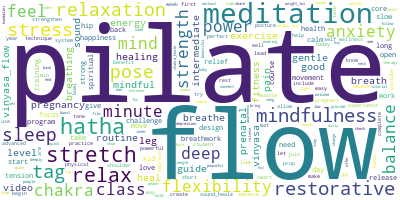

In [143]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

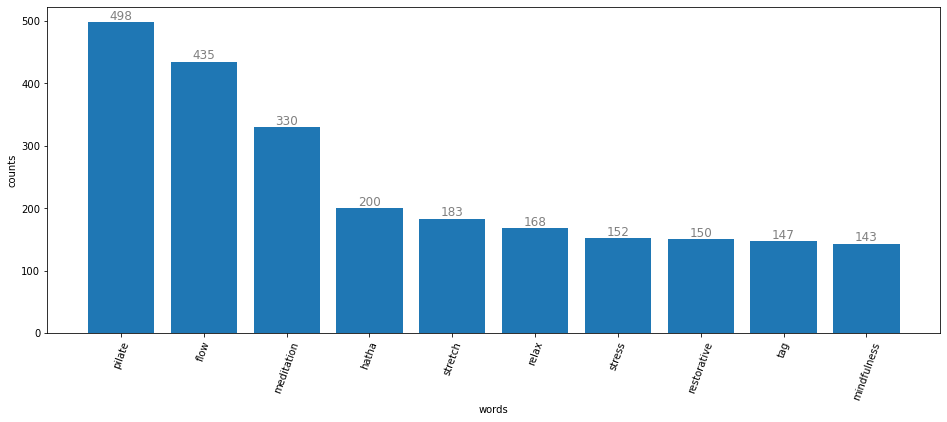

In [144]:
import operator
import matplotlib.pyplot as plt

word_freq = []
word_list = []
count_dict = {}
for n in id2word.values():
    count_dict[n] = list_of_words.count(n)
sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dict)), [val[1] for val in sorted_dict], align='center')
plt.xticks(range(len(sorted_dict)), [val[0] for val in sorted_dict])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')
    
plt.show()

In [148]:
# build initial model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=20, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [149]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.293*"pilate" + 0.025*"leg" + 0.021*"fitness" + 0.018*"core" + '
  '0.017*"pilates" + 0.016*"exercise" + 0.012*"workout" + 0.011*"good" + '
  '0.010*"routine" + 0.009*"pilates_fusion"'),
 (1,
  '0.047*"chakra" + 0.022*"spiritual" + 0.020*"give" + 0.019*"class" + '
  '0.018*"guide" + 0.014*"neck" + 0.013*"look" + 0.012*"meditation" + '
  '0.012*"kundalini" + 0.012*"spirituality"'),
 (2,
  '0.046*"prenatal" + 0.045*"pregnancy" + 0.022*"stretch" + 0.018*"pain" + '
  '0.018*"exercise" + 0.017*"pregnant" + 0.016*"relief" + 0.014*"hip" + '
  '0.014*"strengthen" + 0.013*"fitness"'),
 (3,
  '0.035*"relax" + 0.015*"flow" + 0.015*"water" + 0.014*"flexibility" + '
  '0.013*"challenge" + 0.013*"training" + 0.013*"calm" + 0.013*"strength" + '
  '0.012*"breathwork" + 0.011*"length"'),
 (4,
  '0.034*"restorative" + 0.031*"routine" + 0.024*"relaxation" + 0.021*"feel" + '
  '0.021*"relax" + 0.020*"tension" + 0.019*"short" + 0.016*"stress" + '
  '0.014*"deep" + 0.013*"challenge"'),
 (5,
  '0.02

In [150]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.370926629189691


In [151]:
# tune hyperparameters
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [152]:
from sklearn.model_selection import GridSearchCV

In [153]:
grid = {min_topics=2}
GridSearchCV(lda_model)

TypeError: __init__() missing 1 required positional argument: 'param_grid'

In [26]:
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [14:20<00:00,  1.59s/it]


In [38]:
results = pd.DataFrame(model_results)

In [39]:
results.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.394415
1,75% Corpus,2,0.01,0.31,0.394415
2,75% Corpus,2,0.01,0.61,0.408774
3,75% Corpus,2,0.01,0.91,0.397002
4,75% Corpus,2,0.01,symmetric,0.394415


In [29]:
results.loc[(results['Alpha']==0.01) & (results['Beta']==0.01)]

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.394415
30,75% Corpus,3,0.01,0.01,0.341816
60,75% Corpus,4,0.01,0.01,0.381495
90,75% Corpus,5,0.01,0.01,0.368847
120,75% Corpus,6,0.01,0.01,0.372465
150,75% Corpus,7,0.01,0.01,0.366562
180,75% Corpus,8,0.01,0.01,0.379629
210,75% Corpus,9,0.01,0.01,0.312478
240,75% Corpus,10,0.01,0.01,0.358312
270,100% Corpus,2,0.01,0.01,0.377676


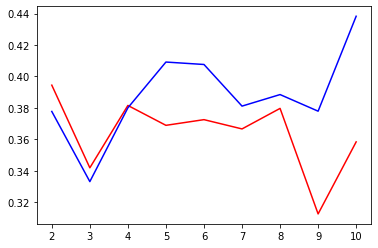

In [30]:
fig, ax = plt.subplots()
ax = plt.plot('Topics', 'Coherence', data=(results.loc[(results['Validation_Set']=='75% Corpus') & (results['Alpha']==0.01) & (results['Beta']==0.01)]), color='red')
ax = plt.plot('Topics', 'Coherence', data=(results.loc[(results['Validation_Set']=='100% Corpus') & (results['Alpha']==0.01) & (results['Beta']==0.01)]), color='blue')

In [31]:
results[(results['Validation_Set']=='100% Corpus') & (results['Coherence']==max(results['Coherence']))]

,Validation_Set,Topics,Alpha,Beta,Coherence
537,100% Corpus,10,asymmetric,0.61,0.464787


In [32]:
# build model with tuned hyper-parameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha='asymmetric',
                                       eta=0.6)

In [33]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4647869893559541


In [34]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"tag" + 0.019*"anxiety" + 0.011*"description" + 0.006*"time" + '
  '0.006*"arm" + 0.006*"basic" + 0.005*"posture" + 0.005*"include" + '
  '0.005*"course" + 0.005*"sex"'),
 (1,
  '0.044*"chakra" + 0.019*"restorative" + 0.019*"guide" + 0.013*"technique" + '
  '0.008*"self" + 0.008*"anxiety" + 0.008*"exercise" + 0.007*"level" + '
  '0.006*"need" + 0.006*"open"'),
 (2,
  '0.030*"prenatal" + 0.014*"rain" + 0.011*"pregnant" + 0.009*"weight_loss" + '
  '0.008*"principiante" + 0.007*"baby" + 0.006*"gentle" + '
  '0.006*"pregnant_woman" + 0.005*"programa" + 0.005*"trimester"'),
 (3,
  '0.024*"strength" + 0.023*"vinyasa" + 0.019*"stretch" + 0.019*"flexibility" '
  '+ 0.019*"total" + 0.014*"leg" + 0.012*"exercise" + 0.011*"pose" + '
  '0.011*"strong" + 0.011*"minute"'),
 (4,
  '0.041*"guide" + 0.010*"anxiety" + 0.009*"well" + 0.008*"help" + '
  '0.007*"pose" + 0.006*"time" + 0.005*"technique" + 0.005*"system" + '
  '0.005*"restorative" + 0.005*"clase"'),
 (5,
  '0.019*"restorative" 

In [35]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [36]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(df_)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df_['Doc'] = doc_num
df_['Topic'] = topic_num
df_['Probability'] = prob
df_.to_csv('doc_topic_matrix.csv', index=False)

In [37]:
def recommend_by_storyline(title, df):
    recommended = []
    top10_list = []

    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    doc_num = df[df['title']==title].Doc.values 

    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)
    index = output_df[output_df['Doc']==doc_num[0]].index[0]

    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)

    output_df['title'] = output_df['title'].str.title()

    for each in top10_list:
        recommended.append(output_df.iloc[each].title)

    return recommended

In [40]:
dir(lda_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alpha',
 'batch',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offset',
 'optimize_al